In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import os
import time
from shapely.geometry import Point, Polygon, LineString,MultiPolygon
from shapely.ops import unary_union
import nltk
import gensim
import string
from mpl_toolkits import mplot3d
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

C:\Users\Krist\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Reading in the area-separating-indices created in 2.AreaBasedWarnings.ipynb

directory = 'AreaIndices/'
i = 0
areaIndices = {}
for filename in os.listdir(directory):
    with open(directory+filename,'r') as textfile:
        obs = textfile.readlines()
        obs = [int(re.sub('\n','',i)) for i in obs]
        name = re.sub('.txt','',filename)
        areaIndices[name] = obs
worldSeas = gpd.read_file('World_Seas_IHO_v3/World_Seas_IHO_v3.shp')

In [50]:
# Reading in the cleaned data
messages = pd.read_csv('CleanedData.csv',index_col=0)
geoMessages = gpd.GeoDataFrame(messages)
labels = pd.read_csv('classLabels.csv')
geoMessages = pd.concat([geoMessages,labels],axis=1)
# Making sure that the dataframe eventually will have a 'valid' geometry column 
geometryList = []
for i,(shape,geom) in enumerate(zip(geoMessages.GeometryType,geoMessages.Coordinates)):
    
    if shape == 'Point':
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]

        coor.append(tuple(ele))
        geo = Point(coor)
        geometryList.append(geo)
        
    elif shape == 'GeometryCollection':
        
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]
        
        tupleCoor = [tuple(ele[i:i+3]) for i in np.arange(0,len(ele),3)]
        if i == 4956 or i == 5681 or i == 1037:
            # Necessary because the three observations are LineStrings, or closer to linestrings than polygons.
            geo = LineString(tupleCoor)
        else:
            geo = Polygon(tupleCoor)
        geometryList.append(geo)

In [51]:
# Storing the geometries in something we can work with.
geometryFrame = gpd.GeoDataFrame(geometry=geometryList,crs=worldSeas.crs)

# Storing the centroids
geometryFrame['Centroids']=geometryFrame.centroid
geometryFrame['CentroidCoor'] = [list(geometryFrame['Centroids'].loc[obs].coords)[0] for obs in geometryFrame.index]
# Creating a reduced dataframe based on the unique coordinates
reducedCentroidCoordinates = geometryFrame.drop_duplicates(subset=['CentroidCoor'])

# Creating the reduced geometry and message dataframe
reducedGeometryFrame = geometryFrame.loc[reducedCentroidCoordinates.index]
reducedGeometryFrame = reducedGeometryFrame.reset_index(drop=True)
reducedGeoMessages = geoMessages.loc[reducedCentroidCoordinates.index]
reducedGeoMessages = reducedGeoMessages.reset_index(drop=True)
# Setting the geometry of the reduced-messages-dataframe
reducedGeoMessages['geometry'] = reducedGeometryFrame['geometry']
reducedGeoMessages['Centroids'] = reducedGeometryFrame['Centroids']
reducedGeoMessages.geometry = reducedGeoMessages['geometry']
reducedGeoMessages.crs = worldSeas.crs
print('This is the areas imported',areaIndices.keys())

This is the areas imported dict_keys(['hydroArc', 'hydroLant', 'hydroPac', 'navareaIV', 'navareaXII'])


In [52]:
avaliableAreas = list(areaIndices.keys())
area0 = reducedGeoMessages.loc[areaIndices[avaliableAreas[0]]]
area1 = reducedGeoMessages.loc[areaIndices[avaliableAreas[1]]]
area2 = reducedGeoMessages.loc[areaIndices[avaliableAreas[2]]]
area3 = reducedGeoMessages.loc[areaIndices[avaliableAreas[3]]]
area4 = reducedGeoMessages.loc[areaIndices[avaliableAreas[4]]]

If one needs to work with all the data, the below is necessary to execute, otherwise just use the above.

In [53]:
# Updating the georeferenced messages with correct geometries
geoMessages['geometry'] = geometryFrame['geometry']
geoMessages['Centroids'] = geometryFrame['Centroids']
geoMessages.geometry = geoMessages['geometry']
geoMessages.crs = worldSeas.crs

# Creating a column in the full and the reduced datasset, which is mergable.
#geometryFrame['CentroidCoor'] = [list(geometryFrame['Centroids'].loc[obs].coords)[0] for obs in geometryFrame.index]
reducedGeometryFrame['CentroidCoor'] = [list(reducedGeometryFrame['Centroids'].loc[obs].coords)[0] for obs in reducedGeometryFrame.index]

# Extracting all the subarea-tags
area = []
for obs in reducedGeometryFrame.index:
    area.append([i for i,subarea in enumerate(areaIndices.keys()) if obs in areaIndices[subarea]][0])
reducedGeometryFrame['Subarea'] = area

# Merging the reduced dataset, with subarea-tags, onto the fulldataset.
mergedCentroids = geometryFrame.merge(reducedGeometryFrame,how='left',on=['CentroidCoor'])

In [54]:
subareasMessages = {subarea : mergedCentroids[mergedCentroids['Subarea']==i].shape[0] for i,subarea in enumerate(areaIndices.keys())}

In [55]:
subareasMessages

{'hydroArc': 6194,
 'hydroLant': 3145,
 'hydroPac': 12455,
 'navareaIV': 25593,
 'navareaXII': 6569}

In [59]:
messages['Subarea'] = mergedCentroids['Subarea']
geoMessages['Subarea'] = mergedCentroids['Subarea']


At this point, it is time to do the topic modelling for each of the sub areas.

In [10]:
stopWords = stopwords.words('english')
with open('english-words-master/words_alpha.txt','r') as vocabulary:
    vocab = vocabulary.readlines()
vocab = {re.sub('\n','',word) : 1 for word in vocab}

In [11]:
additionalWordsRemove = ['authority','date','cancel','dnc','msg','this','email','phone',
                        "thru","meter","depth","metre","float","top",'fax']
singleletters = [chr(i) for i in range(ord('a'),ord('z')+1)]
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
porter = PorterStemmer()
def cleanWords(warning):
    stop_free = ' '.join([word for word in warning.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = [lemma.lemmatize(word) for word in punc_free.split()]
    # It has been decided to not stem the words, as they remove all the standard remarks used conventionally in the warning
    # messages.
    #stemmed = [porter.stem(word) for word in normalized]
    noNumeric = [re.sub('[0-9]','',word) for word in normalized]
    abovethree = [word for word in noNumeric if len(word)>2]
    noAddtional = [word for word in abovethree if word not in additionalWordsRemove]
    noMonths = [word for word in noAddtional if word not in months]
    wordsInvEngVocab = [word for word in noMonths if word in vocab.keys()]
    
    return wordsInvEngVocab

In [22]:
 ##################################################### Processing each subarea ###############################################
topics = 9
NumberOfWords = 4
subareas = 5
# Change the below range if another range is of interest
rangeOfInterst = np.arange(subareas)
wordFrames = [pd.DataFrame(columns=[np.arange(NumberOfWords)]) for i in rangeOfInterst]
probFrames = [pd.DataFrame(columns=[np.arange(NumberOfWords)]) for i in rangeOfInterst]

# See if we have directories, otherwise will they be created later and can be used next the code is being executed 
try:
    directory = 'Dictionaries/'
    loopOver = os.listdir(directory)
    
except:
    noSuchDirectory = ['No Such Directory' for i in np.arange(subareas)]
    loopOver = noSuchDirectory

# Performing the Topic Modelling for each of the subareas
for a,(area,file) in enumerate(zip(areaIndices.keys(),loopOver)):
    print('_________________________________________________________________________________________________________________\n')
    print('The subarea currently being processing is %s' % area,'\n')
    subArea = messages[messages['Subarea']==a]
    print('The number of observations in this subarea is',subArea.shape[0],'\n')
    messages_clean = [cleanWords(subArea['Message'].loc[obs]) for obs in subArea.index]
    
    # Creating the term dictionary of our courpus, where every unique term is assigned an index.
    # The dictonary is either created if not present or reused, as part of ensuring same results everytime the code is 
    # being executed.
    try:
        dictionary=corpora.Dictionary.load(file)
    except:
        # If it is the first time the code is being executed and it is the first subarea, the directory is being created.
        try:
            os.mkdir('Dictionaries')
        # If the directory exists, do nothing and just save the file in there.
        except:
            None
        dictionary = corpora.Dictionary(messages_clean)
        dictionary.save(directory+area+'LdaDictionary')

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in messages_clean]
    
    # Creating the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel
    LdaMulti = gensim.models.ldamulticore
    # Running and Trainign LDA model on the document term matrix.
    #current = 0
    #for numberOfTopics in np.arange(topics,topics+1):
    print('The number of topics are: ',numberOfTopics,'\n')
    ldamodel = LdaMulti.LdaMulticore(doc_term_matrix, num_topics=topics, id2word = dictionary,
                                     passes=50, random_state=2019)

    for line in ldamodel.print_topics(num_topics=topics, num_words=4):

        tempWords = [re.sub('[0-9*".]','',i) for i in line[1].split() if '+' not in i]
        tempProbs = [float(re.sub('[a-z*"]','',i)) for i in line[1].split() if '+' not in i]
        #tempWords = tempWords[0:3]+[tempWords[np.random.randint(len(tempWords))]]
        wordFrames[a].loc[line[0]] = tempWords
        probFrames[a].loc[line[0]] = tempProbs

        print(line,'\n')
        #current += 1

_________________________________________________________________________________________________________________

The subarea currently being processing is hydroArc 

The number of observations in this subarea is 6194 

The number of topics are:  9 

(0, '0.218*"vicinity" + 0.068*"vessel" + 0.044*"requested" + 0.044*"keep"') 

(1, '0.220*"area" + 0.176*"bound" + 0.173*"operation" + 0.166*"daily"') 

(2, '0.619*"reported" + 0.144*"shoal" + 0.142*"iceberg" + 0.091*"antarctica"') 

(3, '0.066*"six" + 0.062*"area" + 0.061*"mile" + 0.061*"operation"') 

(4, '0.091*"mile" + 0.090*"survey" + 0.088*"bound" + 0.088*"berth"') 

(5, '0.277*"established" + 0.277*"mooring" + 0.277*"scientific" + 0.095*"subsurface"') 

(6, '0.116*"berth" + 0.116*"requested" + 0.105*"one" + 0.100*"mile"') 

(7, '0.274*"mooring" + 0.274*"scientific" + 0.100*"removed" + 0.100*"remain"') 

(8, '0.235*"station" + 0.223*"remote" + 0.144*"resolute" + 0.101*"frequency"') 

__________________________________________________

In [13]:
print('Raw message:\n\n',messages['Message'].loc[0])
print('\nCleaned message:\n\n',cleanWords(messages['Message'].loc[0]))

Raw message:

 BOTTOM SCIENTIFIC MOORING EXTENDING 3.5 METERS ABOVE SEA FLOOR ESTABLISHED IN  70-33.48N 127-41.33W AT DEPTH 40 METERS.//

Cleaned message:

 ['bottom', 'scientific', 'mooring', 'extending', 'sea', 'floor', 'established']


In [47]:
#for i in np.arange(5):
print('Topic-associated words for area:\n\n',list(areaIndices.keys())[4])
wordFrames[4]

Topic-associated words for area:

 navareaXII


,0,1,2,3
0,station,guam,dangerous,wreck
1,reported,obstruction,mile,area
2,within,mile,area,navigation
3,vicinity,adrift,derelict,wooden
4,mooring,established,scientific,xii
5,vicinity,vessel,sharp,keep
6,operation,missile,vessel,area
7,light,unlit,unreliable,punta
8,area,bound,daily,operation


In [60]:
geoMessages

,Area,Chart,Message,Authority,Date,StartDate,EndDate,BroadcastingDate,GeometryType,geometry,Coordinates,Unnamed: 0,Label,Centroids,Subarea
0,CANADA-NORTH COAST. /BEAUFORT SEA.,15940,BOTTOM SCIENTIFIC MOORING EXTENDING 3.5 METERS...,NAVAREA XVII,No date listed,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-127.688834 70.55800000000001 0),"[(-127.688834, 70.558, 0.0)]",0,6,POINT (-127.688834 70.55800000000001),0
1,ARCTIC. /BEAUFORT SEA.,15945,"SCIENTIFIC MOORINGS, TOP FLOAT 29 METERS, ESTA...",NAVAREA XVII,No date listed,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-133.714 70.0585 0),"[(-133.714, 70.0585, 0.0)]",1,6,POINT (-133.714 70.0585),0
2,ARCTIC. /BEAUFORT SEA.,15945,"SCIENTIFIC MOORINGS, TOP FLOAT 29 METERS, ESTA...",NAVAREA XVII,No date listed,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-133.717167 70.0585 0),"[(-133.717167, 70.0585, 0.0)]",2,6,POINT (-133.717167 70.0585),0
3,ARCTIC./CHUCKCHI SEA.,16003,"SCIENTIFIC MOORING, TOP FLOAT 971 FEET, ESTABL...",CGC HEALY,No date listed,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-158.410434 72.7996 0),"[(-158.410434, 72.7996, 0.0)]",3,6,POINT (-158.410434 72.7996),0
4,ARCTIC./CHUKCHI SEA.,16003.,DNC 27. SCIENTIFIC MOORING ESTABLISHED VICINIT...,NAVAREA XVII,No date listed,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-158.702167 72.615167 0),"[(-158.702167, 72.615167, 0.0)]",4,5,POINT (-158.702167 72.615167),0
5,ARCTIC./CHUKCHI SEA.,16003.,DNC 27. SCIENTIFIC MOORING ESTABLISHED VICINIT...,NAVAREA XVII,No date listed,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-158.412667 72.800167 0),"[(-158.412667, 72.800167, 0.0)]",5,5,POINT (-158.412667 72.800167),0
6,ARCTIC./BEAUFORT SEA./DNC 27.,15926.,"SCIENTIFIC MOORING, AT DEPTH 61 METERS, ESTABL...",NAVAREA XVII,2015-10-01 00:00:00,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-139.020667 70.432334 0),"[(-139.020667, 70.432334, 0.0)]",6,6,POINT (-139.020667 70.432334),0
7,ARCTIC./BEAUFORT SEA./DNC 27.,15926.,"SCIENTIFIC MOORINGS, AT DEPTH 183 METERS AND A...",NAVAREA XVII,2015-10-02 00:00:00,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-135.011 70.86966700000001 0),"[(-135.011, 70.869667, 0.0)]",7,6,POINT (-135.011 70.86966700000001),0
8,ARCTIC./BEAUFORT SEA./DNC 27.,15926.,"SCIENTIFIC MOORINGS, AT DEPTH 183 METERS AND A...",NAVAREA XVII,2015-10-02 00:00:00,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-135.019167 70.869 0),"[(-135.019167, 70.869, 0.0)]",8,6,POINT (-135.019167 70.869),0
9,ARCTIC./CHUKCHI SEA./DNC 27.,16005.,SUB-SURFACE SCIENTIFIC MOORINGS ESTABLISHED IN...,USCGC HEALY,2016-08-04 00:00:00,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-06-01,Point,POINT Z (-161.500184 71.600117 0),"[(-161.500184, 71.600117, 0.0)]",9,6,POINT (-161.500184 71.600117),0


In [138]:
subAreaLabels = pd.DataFrame(index=[('Topic '+str(i)) for i in np.arange(9)]+['No Label'],#,'Total'
                             columns =[i for i in areaIndices.keys()]+['Total'])
subAreaTotal = [geoMessages[(geoMessages['Label'] == j)].shape[0] for j in np.arange(10)]
for i,subarea in enumerate(list(areaIndices.keys())+['Total']):
    if i < 5:
        subAreaPercentage = [geoMessages[(geoMessages['Subarea'] == i) & (geoMessages['Label'] == j)].shape[0] for j in np.arange(10)]
        subAreaPercentage = np.array(subAreaPercentage) / np.array(subAreaTotal)
        subAreaLabels.loc[0:10,subarea] = np.round(subAreaPercentage,3)*100
    else:
        subAreaPercentage = subAreaTotal[:]
        subAreaLabels.loc[0:10,subarea] = subAreaPercentage

In [140]:
subAreaLabels

,hydroArc,hydroLant,hydroPac,navareaIV,navareaXII,Total
Topic 0,0,0,0.1,97.7,2.2,1325
Topic 1,0,2.4,30.7,65,1.9,7275
Topic 2,2,13.4,38.3,40,6.3,3792
Topic 3,5.8,7.7,26.7,47.3,12.4,13520
Topic 4,31.1,4.3,5.4,40.7,18.6,7763
Topic 5,27.4,1.1,26.2,11.3,34.1,558
Topic 6,51.2,3.5,6.6,20.4,18.3,4609
Topic 7,0,12,19.1,57.6,11.2,5364
Topic 8,2.9,3.7,27.7,49.6,16.2,7235
No Label,7.9,0.4,50,32.5,9.3,2515


In [136]:
labelsInArea = pd.DataFrame(index=[('Topic '+str(i)) for i in np.arange(9)]+['No Label','Total'],#
                             columns =[i for i in areaIndices.keys()])
subAreaTotal = [geoMessages[(geoMessages['Subarea'] == j)].shape[0] for j in np.arange(len(areaIndices.keys()))]
for i,subarea in enumerate(areaIndices.keys()):
    if i < 5:
        subAreaPercentage = [geoMessages[(geoMessages['Subarea'] == i) & (geoMessages['Label'] == j)].shape[0] for j in np.arange(10)]
        subAreaPercentage = np.array(subAreaPercentage) / np.array(subAreaTotal[i])
        labelsInArea.loc[0:10,subarea] = np.round(subAreaPercentage,3)*100
labelsInArea.loc['Total'] = subAreaTotal

In [137]:
labelsInArea

,hydroArc,hydroLant,hydroPac,navareaIV,navareaXII
Topic 0,0,0,0,5.1,0.4
Topic 1,0,5.6,17.9,18.5,2.1
Topic 2,1.2,16.2,11.7,5.9,3.7
Topic 3,12.7,33.1,29,25,25.5
Topic 4,38.9,10.6,3.3,12.3,21.9
Topic 5,2.5,0.2,1.2,0.2,2.9
Topic 6,38.1,5.1,2.5,3.7,12.8
Topic 7,0,20.5,8.2,12.1,9.2
Topic 8,3.4,8.4,16.1,14,17.9
No Label,3.2,0.3,10.1,3.2,3.5


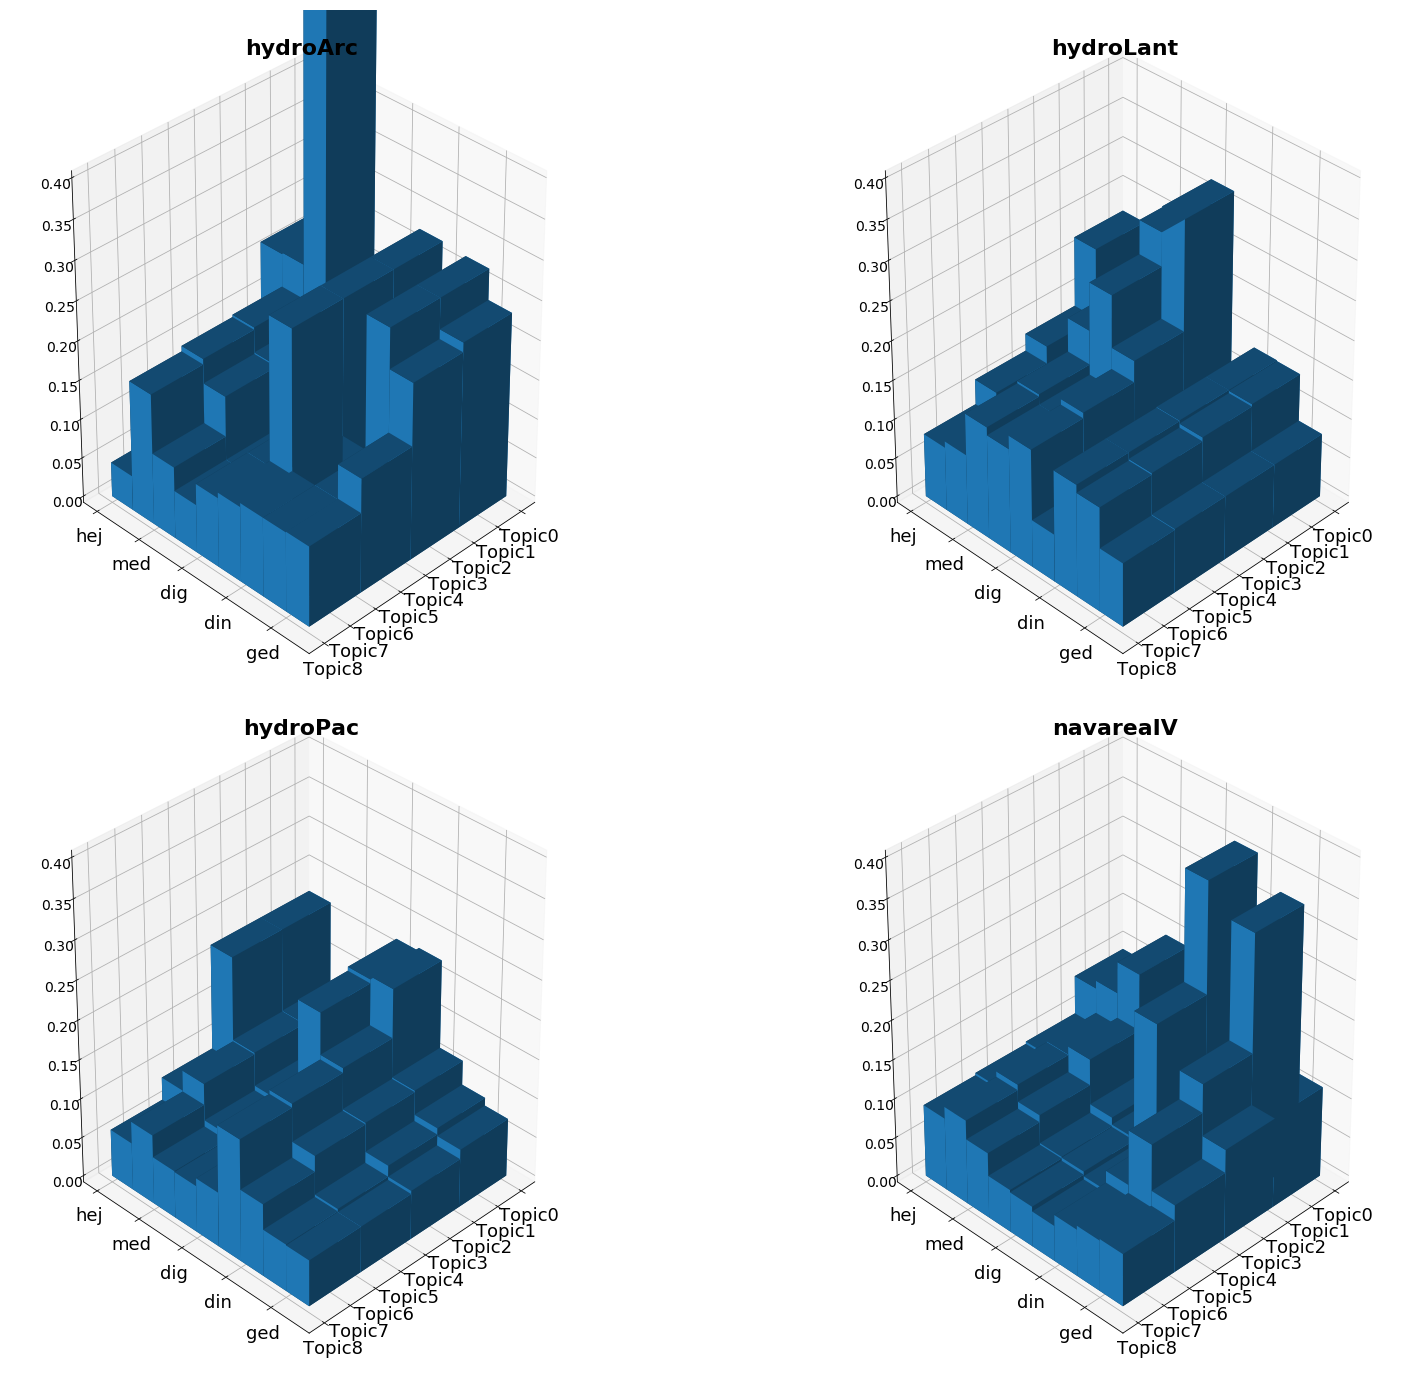

In [30]:
# setup the figure and axes
fig = plt.figure(figsize=(25, 25))
#ax = fig.add_subplot(1,2,2,projection='3d')
fig.subplots_adjust(hspace=0, wspace=0.4)
_x = np.arange(4)
_y = np.arange(9)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
bottom = np.zeros_like(x)
areas = list(areaIndices.keys())

font = {'size'   : 14}

plt.rc('font', **font)

for i,frame in enumerate(probFrames[0:4]):

    z = []
    [z.append(frame.loc[i]) for i in np.arange(9)]
    z = np.meshgrid(z)[0]
    z = z.ravel()
    
    ax = fig.add_subplot(2,2,i+1,projection='3d')
    ax.bar3d(x=x,y=y,z=bottom,dx=1,dy=1,dz=z,shade=True)#
    ax.set_zlim(0,0.40)
    ax.set_xticklabels(['Topic'+str(i) for i in frame.index],fontsize = 18)
    ax.set_yticklabels(['hej','med','dig','din','ged'],fontsize = 18)
    ax.set_title(areas[i],fontsize= 22,fontdict={'verticalalignment':'bottom','weight':'bold'})
    ax.view_init(30, 45)

In [15]:
z =np.meshgrid(probFrames[0])

In [16]:
z= []

for i in np.arange(5):
    z.append(list(probFrames[0].loc[i]))



In [17]:
z

[[0.234, 0.066, 0.043, 0.043, 0.043],
 [0.226, 0.185, 0.184, 0.164, 0.123],
 [0.619, 0.15, 0.139, 0.089, 0.0],
 [0.176, 0.168, 0.112, 0.077, 0.056],
 [0.085, 0.083, 0.083, 0.082, 0.082]]

In [18]:
# fake data


top = x + y


In [19]:
_xx

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [20]:
top

array([0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5,
       6, 7, 8])